In [157]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RXGate
from math import sqrt
from numpy.linalg import eigvalsh
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
import pdflatex
from scipy.optimize import minimize
import time
from qiskit.quantum_info import state_fidelity
import pandas as pd 

# Simulation of the Schwinger model using a VQE
In this notebook we will explore a numerical simulation (trough the use of a Variational Quantum Eigensolver) of the Schwinger model. The whole notebook, including its structure, its methods and the obtained resuilts, is based on the work [1]. The main focus is then to try and repiclate the results of the paper. 
First of all, we will dig in into some theoretical insights of the model: we mainly review the Lagrangian and Hamiltonian formulation for a spin $\displaystyle \frac{1}{2}$ field $\psi$ which will be essential to obtain the discretized version of the Hamiltonian on a one-dimensional lattice. This is the Hamiltonian we intend to minimize trought the use of the VQE algorithm. 


## Schwinger model
The Schwinger model is a description of Quantum Electrodynamics (QED) coupled to a massive Dirac fermion $\psi$ in $(1+1)-$ dimensions.
We can thus start from the general (3+1)-dimensions gauge invariant Lagrangian density describing the system 
\begin{equation*}
\mathcal{L} = \bar{\psi}(i\not{D}-m)\psi, 
\end{equation*}
where $\psi(x)$ is, in general, a four-component Dirac spinor, whose components $\psi(x)_{\alpha}, \alpha = 1,2,3,4$ fulfill the standard fermionic anticommutation relations 
\begin{equation*}
\{\psi^{\dagger}_{\alpha} (x), \psi_{\beta}(y)\} = \{\psi^{\dagger}_{\alpha}(\vec{x},t), \psi_{\beta}(\vec{y},t)\} = \delta^{3}(\vec{x}-\vec{y})\delta_{\alpha,\beta},
\end{equation*}
and $\not{D} = D_{\mu}\gamma^{\mu}$, where $D_{\mu} = \partial_\mu + ig A_{\mu}$ is the covariant derivative, which guarantees that $\mathcal{L}$ is invariant under $U(1)$ local transformation $\psi \to e^{iq\theta(x)}\psi, \bar{\psi} \to e^{-iq\theta(x)}\bar{\psi}$. $A_{\mu}$ is the gauge field that mediates bewteen the matter fields and $\gamma^{\mu}$ are the set of the four Dirac matric satisfying Clifford algebra $\{\gamma^{\mu}, \gamma^{\nu}\} = 2 \eta^{\mu\nu}$ with $\eta = \text{diag}(1,-1,-1,-1)$.


Writing $\mathcal{L}$ as
$$\mathcal{L} = \bar{\psi}(i\partial_{\mu}\gamma^{\mu}-qA_{\mu}{\gamma^{\mu}}-m)\psi $$
enables us to compute the Hamlitonian density
$$\mathcal{H} = \pi^{o}(x)\partial_{0}\psi + \bar{\pi}^{0}(x)\partial_{0}\bar{\psi} - \mathcal{L}$$
where 
$$
\pi^{\mu}(x) = \frac{\partial \mathcal{L}}{\partial(\partial_{\mu}\psi) } = i\bar{\psi}\gamma^{\mu} \quad \bar{\pi}^{\mu}(x) = \frac{\partial \mathcal{L}}{\partial(\partial_{\mu}\bar{\psi}) } = 0.
$$
The Hamiltonian density thus becomes 
$$
\boxed{ \mathcal {H}= -\bar{\psi}(i\partial_i \gamma^{i}- q (A_0\gamma^{0}+A_i\gamma^{i})-m)\psi}
$$
and the corresponding Hamiltonian 
$$
H = \int{d^{3}\vec{x}} \mathcal{H} =  -\int{d^{3}\vec{x}}\bigg[\bar{\psi}(x)(i\partial_i \gamma^{i}- q (A_0\gamma^{0}+A_i\gamma^{i})-m)\psi(x)\bigg]
$$
Now, choosing the temporal gauge $A_0 = 0 $, in $(1+1)-$ dimensions, the hamiltonian density of the Scwhinger model becomes
$$\boxed{\mathcal{H} = -i\bar{\psi}\gamma^{1}(\partial_1+igA_{1})+ m \bar{\psi}\psi}$$
and the corresponding Hamiltonian
$$
\boxed{
    H = \int{dx} \mathcal{H} =  -i\int {dx}\bigg[\bar{\psi}(x)\gamma^{1}(\partial_1+igA_{1})+ m \bar{\psi}\psi(x)\bigg]
}
$$
where, in this case, $\psi(x)$ is a two-component Dirac spinor, whose components  $\psi(x)_{\alpha}, \alpha = 1,2$  obey 
$$
\{\psi^{\dagger}_{\alpha} (x), \psi_{\beta}(y)\} = \delta({x}-{y})\delta_{\alpha,\beta}.
$$
$A_{\mu}, \mu = 0,1 $ is the gauge field and $\gamma^{\mu}$ are two-dimensional matrices obeying Clifford algebra $\{\gamma^{\mu}, \gamma^{\nu}\} = 2 \eta^{\mu\nu}$ with $\eta = \text{diag}(1,-1)$. 

In the presence of a topological $\theta$ term we have 
$$ 
\boxed{ \mathcal {H}= -i\bar{\psi}\gamma^{1}(\partial_1+igA_{1})+ m \bar{\psi}\psi+ \frac{1}{2}\left( \partial_0 A_1+\frac{g\theta}{2\pi}\right)^2}
$$
and 
$$\boxed{H = \int {dx}\mathcal{H} = \int {dx}\bigg[ -i\bar{\psi}(x)\gamma^{1}(\partial_1+igA_{1})+ m \bar{\psi}\psi(x)+ \frac{1}{2}\left( \partial_0 A_1+\frac{g\theta}{2\pi}\right)^2\bigg]}  $$
The topological term, $g\theta/2\pi$, appearing in the Hamiltonian corresponds to a constant background electric field. 
The corresponding conserved current related to the $U(1)$ invariance is $j^{\mu} = g \bar{\psi}\gamma^{\mu}\psi$, which, trough Gauss's law, imposes a constraint on the gauge field
$$ - \partial_ 0 A_1 = g \bar{\psi}\gamma^{0}\psi$$
where where $-\partial_0 A_1$ is the electric field (in the temporal gauge) and $ g \bar{\psi}\gamma^{0}\psi$ represents the
charge density.

## Wilson's formulation
The discretized Hamiltonian in this formulation is given by 
$$
H_W = 
\sum_{n=0}^{N-2} \left( 
    \bar{\phi}_n \left( \frac{r + i \gamma^1}{2a} \right) U_n \phi_{n+1} + \text{h.c.}
\right)
+ \sum_{n=0}^{N-1} \left( m_{\text{lat}} + \frac{r}{a} \right) \bar{\phi}_n \phi_n
+ \sum_{n=0}^{N-2} \frac{a g^2}{2} \left( L_n + l_0 \right)^2.
$$

The field $\phi_n$ is a dimensionless Dirac spinor with two components, $\phi_{n,\alpha}$ for $\alpha = 1, 2$, located at lattice site $n$. These components obey the fermionic anticommutation relation:

$$
\{ \phi_{n,\alpha}^\dagger, \phi_{n',\beta} \} = \delta_{nn'} \delta_{\alpha\beta}.
$$

Operators $U_n$ and $L_n$ act on the links connecting neighboring lattice sites $n$ and $n+1$, with $L_n$ representing the quantized, dimensionless electric field. They satisfy the commutation relation:

$$
[U_n, L_{n'}] = \delta_{nn'} U_n,
$$

which implies that $U_n$ lowers the electric flux by one unit in the eigenbasis of $L_n$.

The parameters $m_{\text{lat}}$ and $g$ correspond to the lattice mass and coupling constant, respectively. The Wilson parameter $r$ is introduced to remove fermion doublers and can be chosen arbitrarily in the interval $(0, 1]$ to ensure the correct continuum limit.

The background electric field is given by $l_0 = \theta / 2\pi$, representing the lattice version of the topological $\theta$-term. On the lattice, Gauss’s law takes the form:

$$
L_n - L_{n-1} = Q_n \tag{4}
$$

where the charge operator is defined as $Q_n = \phi_n^\dagger \phi_n - 1$. Because of the global $U(1)$ symmetry of the model, the total charge $\sum_n Q_n$ is conserved.


For the Wilson discretization, the **particle number operator** can be defined as:

$$
P_W = N + \sum_{n=0}^{N-1} \bar{\phi}_n \phi_n, \tag{6}
$$

which essentially represents the lattice version of the **chiral condensate**, $\bar{\psi} \psi$, up to the additive constant $N$.

This constant ensures that $P_W$ is a **positive semidefinite operator**. The lowest possible eigenvalue of $P_W$ is zero, which corresponds to states that minimize the expression $\sum_{n=0}^{N-1} \bar{\phi}_n \phi_n$.

Such states are associated with the **ground state** configuration of the lattice system.
Imposing open boundary conditions it can be shown that $\displaystyle L_n = \sum_{k=0}^{n}Q_k$. In light of this the Hamiltonian becomes
$$
H_W = \sum_{n=0}^{N-2} \left( \bar{\phi}_n \left( \frac{r + i \gamma^1}{2a} \right) \phi_{n+1} + \text{h.c.} \right)
+ \sum_{n=0}^{N-1} \left( m_{\text{lat}} + \frac{r}{a} \right) \bar{\phi}_n \phi_n 
+ \sum_{n=0}^{N-2} \frac{a g^2}{2} \left( l_0 + \sum_{k=0}^{n} Q_k \right)^2.
\tag{8}
$$
With $r=1, \gamma^0 = X$ and $\gamma^1 = iZ$ ($X$ and $Z$ being the usual Pauli gates), applying a Jordan-Wigner transformation to map the fermionic fields into spin operators we finally obtain the dimensionless spin formulation for the Hamiltonian 
$$
\boxed{W_W = x \sum_{n=0}^{N-2} \left( X_{2n+1} X_{2n+2} + Y_{2n+1} Y_{2n+2} \right)
+ \left( \frac{m_{\text{lat}}}{g} \sqrt{x} + x \right) \sum_{n=0}^{N-1} \left( X_{2n} X_{2n+1} + Y_{2n} Y_{2n+1} \right)
+ \sum_{n=0}^{N-2} \left( l_0 + \sum_{k=0}^{n} Q_k \right)^2}.
$$

Here, the parameter $x = 1 / (a g)^2$ represents the inverse lattice spacing squared in units of the coupling constant.

The charge operator in the spin formulation is defined as:

$$
Q_n = \frac{1}{2}(Z_{2n} + Z_{2n+1}),
$$

where $X_n$, $Y_n$, and $Z_n$ are the standard Pauli matrices acting on spin site $n$.

# Defining the ansatz 
First of all start by constructing the two ansatzes (parametrci quantum circuits) used in the minimization procedure.
The first ansatz we consider is the $SO(4)$ circuit 

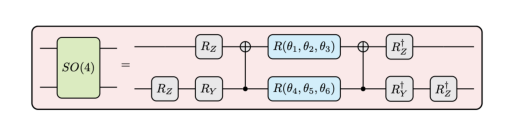

In [158]:
img = mpimg.imread('/Users/lorenzospera/Desktop/S_model/S04.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [159]:
all_thetas = ParameterVector("θ", length = 6)

In [160]:
def create_SO4(params):
    """
    Function that creates the SO4 circuit.
    thetas : vector of parameters used in the circuit 
    """
    qc = QuantumCircuit(2)
    rotation_angle = np.pi/2
    qc = QuantumCircuit(2)
    qc.rz(rotation_angle, 1)
    
    qc.rz(rotation_angle, 0)
    qc.ry(rotation_angle, 1)
    
    qc.cx(1, 0)
    # rotation R(theta1, theta2, theta3)
    qc.rx(params[2], 0)
    qc.rz(params[1], 0)
    qc.rx(params[0], 0)

    qc.rx(params[5], 1)
    qc.rz(params[4], 1)
    qc.rx(params[3], 1)

    qc.cx(1, 0)
    
    qc.rz(rotation_angle, 0).inverse()              # or one can use R_n(theta)^+ = R_n(-theta) where n is a generic one unit vector
    qc.ry(rotation_angle, 1).inverse()
    
    qc.rz(rotation_angle, 1).inverse()

    return qc

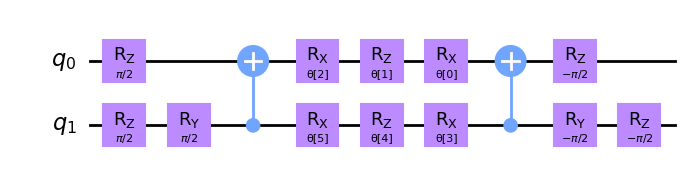

In [161]:
SO4_ansatz = create_SO4(all_thetas)
SO4_ansatz.draw(output = "mpl", style = "clifford")

The other ansatz is the $R_{XX+YY}$ defined as 

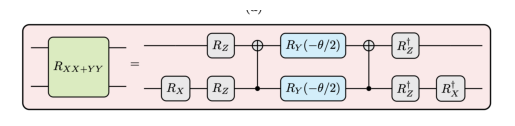

In [162]:
img = mpimg.imread('/Users/lorenzospera/Desktop/S_model/R_XXYY.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [163]:
def create_R_XXYY(param):
    """
    Function that creates the SO4 circuit.
    params : vector of parameters used in the circuit 
    """
    qc = QuantumCircuit(2)
    rotation_angle = np.pi/2
    qc = QuantumCircuit(2)
    qc.rx(rotation_angle, 1)
    
    qc.rz(rotation_angle, 0)
    qc.rz(rotation_angle, 1)
    
    qc.cx(1, 0)

    # Parametrized rotations 
    qc.ry(-param/2, 0)
    qc.ry(-param/2, 1)


    qc.cx(1, 0)
    
    qc.rz(rotation_angle, 0).inverse()              # or one can use R_n(theta)^+ = R_n(-theta) where n is a generic one unit vector
    qc.rz(rotation_angle, 1).inverse()
    
    qc.rx(rotation_angle, 1).inverse()
    

    return qc

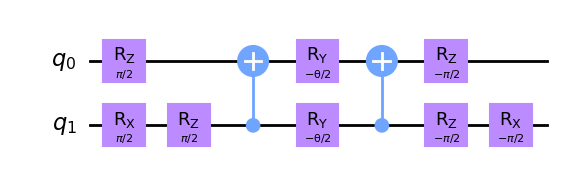

In [164]:
# create an example of the R_XXYY circuit 
theta = Parameter("θ")
R_XXYY = create_R_XXYY(theta)
R_XXYY.draw(output = "mpl", style = "clifford")

# Defining the Hamiltonian 
$$
\boxed{W_W = x \sum_{n=0}^{N-2} \left( X_{2n+1} X_{2n+2} + Y_{2n+1} Y_{2n+2} \right)
+ \left( \frac{m_{\text{lat}}}{g} \sqrt{x} + x \right) \sum_{n=0}^{N-1} \left( X_{2n} X_{2n+1} + Y_{2n} Y_{2n+1} \right)
+ \sum_{n=0}^{N-2} \left( l_0 + \sum_{k=0}^{n} Q_k \right)^2}.
$$
Now we turn our attention to the discretized Hamiltonian of the system and write it in terms of Pauli strings. 
In writing the Hamiltonian it is useful to expand the last term as 
$$
\left(l_0+\sum_{k =0 }^{n}Q_k \right)^2 = l_0^2 + 2l_0\sum_{k = 0}^{n} Q_k + \sum_{j = 0}^{n}\sum_{k = 0}^{n}Q_jQ_k
$$
where 
$$
Q_k = \frac{1}{2}(Z_{2k}+ Z_{2k+1})
$$

In [165]:
# we will now create a function which construct the discretized Hamiltonian of the system in the general case of N qubits 
def create_discretized_hamiltonian(N, x, m_lat, g, l0):
    """
    Function that creates the discretized Hamiltonian used in the VQE
    Inputs: 
    N = number of qubits 
    x = 1/(ag)^2 is the inverse lattice spacing in units of the coupling costant g 
    m_lat = mass of the lattice 
    g = coupling constant 
    l0 = θ/2*pi is linked to the topological term in the Hamiltonian 

    The fucntion returns the fully discretized lattice Hamiltonian of the Schwinger model 
    """

    # as we have already stated, having 2 components at each site leads (Jordan-Wigner transformation) to 2N qubits 
    num_qubits = 2 * N 
    pauli_strings_first_term =  []                               # list of Pauili strings for the first term
    pauli_strings_second_term = []                               # list of Pauili strings for the second term
    pauli_strings_third_term =  []                               # list of Pauili strings for the third term
    pauli_coeffs_first_term =   []                               # list of coefficients of each Pauli string for the first term
    pauli_coeffs_second_term =  []                               # list of coefficients of each Pauli string for the second term
    pauli_coeffs_third_term =   []                               # list of coefficients of each Pauli string for the third term


    # define helper to create each Pauli_string 
    def pauli_string(label_dict):
        """ label_dict: {index: 'X'/'Y'/'Z'}"""
        label = ['I'] * num_qubits                              # returns a list of all identity matrix  

        # associate to each index the corresponding Pauli matrix 
        for indx, pauli in label_dict.items():
            label[indx] = pauli
        return ''.join(reversed(label))                         # compacts the list into a string (as usual for Pauli strings) i.e : ['I', 'Z', 'X] -> 'IZX'

        # we want the reversed string (standard Qiskit convention):  qubit 0 is on the rightmost character
        # see for example the next code section

    # let us now construct the Hamiltonian term by term 

    # -- First term of the Hamiltonian -- 
    for n in range(N-1):                                                        # sum must include the term N - 2
        for pauli in ['X', 'Y']:
            ind_paul_dict = {2*n +1 : pauli, 2*n+2 : pauli}                     # term of the form X_{2n+1}X_{2n+2} or Y_{2n+1}Y_{2n+2}
            pauli_strings_first_term.append(pauli_string(ind_paul_dict))
            pauli_coeffs_first_term.append(x)

    # write the first term as a combination of Pauli strings each weighted with its corresponding coefficient 
    first_term_hamiltonian = SparsePauliOp(data = pauli_strings_first_term, coeffs = pauli_coeffs_first_term)

    # -- Second term of the Hamiltonian -- 
    coefficient = (m_lat/g)*sqrt(x) + x

    for n in range(N):                                                          # sum must include the term N - 1 
        for pauli in ['X', 'Y']:
            ind_paul_dict = {2*n : pauli, 2*n +1 : pauli}
            pauli_strings_second_term.append(pauli_string(ind_paul_dict))
            pauli_coeffs_second_term.append(coefficient)

    # write the first term as a combination of Pauli strings each weighted with its corresponding coefficient 
    second_term_hamiltonian = SparsePauliOp(data = pauli_strings_second_term, coeffs = pauli_coeffs_second_term)

    # -- Third Term -- 
    # as discussed earlier, to write the third term it is convenient expand the square and consider the 3 resulting terms 

    for n in range(N-1):                                                        # sum must include the term N-2
        # 1) First term: l0^2 * Identity
        pauli_strings_third_term.append(pauli_string({}))
        pauli_coeffs_third_term.append(l0 ** 2)

        # 2) Single-Q_k terms: 2 * l0 * Q_k (summed over k in the range [0,n]) (second term)
        for k in range(n + 1):
            for offset in [0, 1]:
                z_index = 2 * k + offset
                label = pauli_string({z_index: 'Z'})
                pauli_strings_third_term.append(label)
                pauli_coeffs_third_term.append(l0)                             # the coeficient is l_0, because in the product we have 2 * l_0 * (Z_{2k}+ Z_{2k+1})/2 = l_0 * (Z_{2k}+ Z_{2k+1})

        # 3) Q_k * Q_j terms  (third term)
        for k in range(n + 1):
            for j in range(n + 1):
                for offset_k in [0, 1]:
                    for offset_j in [0, 1]:
                        idx_k = 2 * k + offset_k
                        idx_j = 2 * j + offset_j

                        # Build Pauli string for Z_i * Z_j
                        if idx_k == idx_j:
                            # Z_i * Z_i = Identity
                            label = pauli_string({})
                            coeff = 0.25
                        else:
                            label = pauli_string({idx_k: 'Z', idx_j: 'Z'})
                            coeff = 0.25

                        pauli_strings_third_term.append(label)
                        pauli_coeffs_third_term.append(coeff)

        third_term_hamiltonian = SparsePauliOp(data = pauli_strings_third_term, coeffs = pauli_coeffs_third_term)
        

    full_hamiltonian = first_term_hamiltonian + second_term_hamiltonian + third_term_hamiltonian
    return full_hamiltonian

In [166]:
ham = create_discretized_hamiltonian(N = 2, x = 1, m_lat = 1, g = 1, l0 = 1.6)
ham


SparsePauliOp(['IXXI', 'IYYI', 'IIXX', 'IIYY', 'XXII', 'YYII', 'IIII', 'IIIZ', 'IIZI', 'IIII', 'IIZZ', 'IIZZ', 'IIII'],
              coeffs=[1.  +0.j, 1.  +0.j, 2.  +0.j, 2.  +0.j, 2.  +0.j, 2.  +0.j, 2.56+0.j,
 1.6 +0.j, 1.6 +0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])

# Defining the electric field

The elecrtic field in terms of Pauli strings is defined as
$$
\boxed{L_W = l_0 +\frac{1}{2}\sum_{k = 0}^{\lceil{N/2}\rceil-1}(Z_{2k}+Z_{2k+1})}
$$

In [167]:
def create_electric_field_operator(N, l0):
    """
    Function that creates the electric field operator in terms of Pauli strings.
    Inputs:
    - N , number of lattice sites 
    - l0 , parameter related to the topological term in the Hamiltonian

    Retturns:
    - SparsePauliOp representing the electric field operator
    """
    # define helper to create each Pauli_string 
    def pauli_string(label_dict):
        """ label_dict: {index: 'X'/'Y'/'Z'}"""
        label = ['I'] * num_qubits                              # returns a list of all identity matrix  

        # associate to each index the corresponding Pauli matrix 
        for indx, pauli in label_dict.items():
            label[indx] = pauli
        return ''.join(reversed(label))                         # compacts the list into a string (as usual for Pauli strings) i.e : ['I', 'Z', 'X] -> 'IZX'
    
    num_qubits = 2*N
    pauli_strings = []
    pauli_coeffs = []
    pauli_strings_l0 = []
    pauli_coeffs_l0 = []    

    upper_bound = math.ceil(N/2) - 1
    for n in range(upper_bound + 1):
        for offset in [0, 1]:
            z_index = 2 * n + offset
            label = ['I'] * num_qubits
            label[z_index] = 'Z'
            pauli_strings.append(''.join(reversed(label)))
            pauli_coeffs.append(0.5)

    identity_label = 'I' * num_qubits
    l0_op = SparsePauliOp(identity_label, coeffs=[l0])
    electric_field_op = SparsePauliOp(data = pauli_strings, coeffs = pauli_coeffs)

    return electric_field_op + l0_op
    

In [168]:
op = create_electric_field_operator(N = 3, l0 = 1.3)
op

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 1.3+0.j])

# Defining the particle number operator


The particle operator in terms of Pauli strings is defined as 
$$
\boxed{
P_W  = N +\frac{1}{2}\sum_{n = 0}^{N-1}(X_{2n}X_{2n+1}+ Y_{2n}Y_{2n+1})    
}
$$


In [169]:
def create_particle_number_operator(N):
    """
    Function that creates the particle number operator in terms of Pauli strings.
    Inputs:
    - N , number of lattice sites 

    Retturns:
    - SparsePauliOp representing the particle number operator
    """
    # define helper to create each Pauli_string 
    def pauli_string(label_dict):
        """ label_dict: {index: 'X'/'Y'/'Z'}"""
        label = ['I'] * num_qubits                              # returns a list of all identity matrix  

        # associate to each index the corresponding Pauli matrix 
        for indx, pauli in label_dict.items():
            label[indx] = pauli
        return ''.join(reversed(label))                         # compacts the list into a string (as usual for Pauli strings) i.e : ['I', 'Z', 'X] -> 'IZX'
    
    num_qubits = 2 * N
    pauli_strings = []
    pauli_coeffs = []

    for n in range(N):
        for pauli in ['X', 'Y']:
            ind_pauli_dict = {2*n : pauli, 2*n +1: pauli}
            pauli_strings.append(pauli_string(ind_pauli_dict))
            pauli_coeffs.append(0.5)

    # Add the constant term N * Identity
    identity_label = 'I' * num_qubits
    identity_op = SparsePauliOp(identity_label, coeffs=[N])
    
    second_term = SparsePauliOp(data = pauli_strings, coeffs = pauli_coeffs)
    particle_number_op = second_term + identity_op
    return particle_number_op

In [170]:
particle_operator = create_particle_number_operator(N = 3)
particle_operator

SparsePauliOp(['IIIIXX', 'IIIIYY', 'IIXXII', 'IIYYII', 'XXIIII', 'YYIIII', 'IIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 3. +0.j])

# Penalty term for the SO(4) ansatz
In the case of the $SO(4)$ ansatz we recall that the constraint of vanishing total charge must be accounted for manually by adding a quadratic penalty term of the form
$$\lambda \left(\sum_{n=0}^{N-1}Q_n\right)^2$$
where the Lagrange multiplier $\lambda$ has to be chosen sufficiently large so that a ground state with vanishing total charge is obtained.
Just like we did before we can expand the term as follows: 
$$
\lambda \left(\sum_{n = 0}^{N-1}Q_n\right)^2 = \lambda \sum_{n = 0}^{N-1}\sum_{m = 0}^{N-1}Q_nQ_m
$$

In [171]:
def create_penalty_term(N, lam):
    """
    Function that creates the penalty term for the VQE cost function. This term accounts for the constraint of vanishing total charge in the SO(4) ansatz.

    Inputs 
    - N : number of lattice sites
    - lam : Lagrange multiplier for the penalty term

    Returns:
    - SparsePauliOp : the penalty term as a SparsePauliOp which can then be added to the full Hamiltonian
    
    """

    num_qubits = 2*N
    def pauli_string(label_dict):
        """ label_dict: {index: 'X'/'Y'/'Z'}"""
        label = ['I'] * num_qubits                          
        for indx, pauli in label_dict.items():
            label[indx] = pauli
        return ''.join(reversed(label))  
    
    penalty_pauli_strings = []  # list of Pauli strings for the penalty term
    penalty_coeffs = []         # list of coefficients for each Pauli string
    for i in range(N-1):
        for j in range(N-1):
            # Q_i * Q_j terms
            for offest_i in [0,1]:
                for offset_j in [0,1]:
                    idx_i = 2*i + offest_i
                    idx_j = 2*j + offset_j

                    if idx_i == idx_j:
                        # Z_i * Z_i = Identity
                        label= pauli_string({})
                        coeff = 0.25
                    else:
                        label = pauli_string({idx_i: 'Z', idx_j: 'Z'})
                        coeff = 0.25
                    penalty_pauli_strings.append(label)    
                    penalty_coeffs.append(coeff)

    # create the SparsePauliOp for the penalty term 
    penalty_term = SparsePauliOp(data = penalty_pauli_strings, coeffs = penalty_coeffs)

    return lam*penalty_term  

# Implementing the VQE 
First of all we will implement a noisless numerical simulation of the Schwinger model using Qiskit's primitives: `StatevectorEstimator` and `StatevectorSampler` before proceeding to simulating the model on a real quantum device. 

First of all we need to define the cost function to minimize, which, in the VQE algorithm is the expected value of the Hamiltonian of the system on the parametric quantum state created by the ansatz (in our case by the $SO(4)$ or $R_{XX+YY}$ ansatz):
$$
C(\vec{\theta}) = \bra{\psi(\vec{\theta})}\hat{W_{W}}\ket{\psi(\vec{\theta})} \geq E_0
$$
where $E_0$ represent the energy of the ground state of the system; the inequality holds $\forall \vec{\theta}$ by virtue of the variational theorem of quantum mechanics. Our goal is to find an approximation of the lowest energy level (the smallest eigenvalue $\lambda_0$ of the Hamiltonian) by minimizing the cost function trough an optimization procedure:
$$ \min_{\vec{\theta}} \left\{ \bra{\psi(\vec{\theta})}\hat{W_{W}}\ket{\psi{\vec{\theta}}}\right\}$$
where $\vec{\theta}$ represents the parameter vector which caracterizes the ansatz we use. 

## Cost function

In [172]:
# first of all we define the cost function for the VQE 
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
     """ Functions that returns the expected value of the Hamiltonian on the parametric state created by the ansatz.
     The funcion takes as input :
        - params (ndarray): Array of ansatz parameters
        - ansatz (QuantumCircuit): Parameterized ansatz circuit
        - hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        - estimator (Estimator): Estimator primitive instance

    Returns:
        float: Expected value of the Hamiltonian on the parametric state 
    """
     pub = (ansatz, hamiltonian, params)
    
    # get the expectation value of the hamiltonian which is the cost function we wish to minimze 
     cost = estimator.run([pub]).result()[0].data.evs                   

     return cost 

## Reference state 
Before applying the ansatz to produce the parametric state $\ket{\psi(\vec{\theta})}$ it is common practise in variational algorithms to initialise the quantum computer in the $\textit{default state}$ $\ket{0}$, from which we can obtain (trough some suitable transformation) the reference state $\ket{\varrho}$. It is the state $\ket{\varrho}$ which is then evolved to obtain the parametric state $\ket{\psi(\vec{\theta})}$. Usually, as it is true in our case, the reference state $\ket{\varrho}$, is linked to some physical properties of the system and thus, an educated guess can be made about the state $\ket{\varrho}$.  

Defining $U_R$ as 
$$
\ket{\varrho} = U_R\ket{0}
$$ 
and the ansatz $U_V(\vec{\theta})$, the parametric quantum state is then defined as 
$$
\ket{\psi(\vec{\theta})} = U_V(\vec{\theta})\ket{\varrho} = U_V(\vec{\theta})U_R\ket{0}
$$
In the paper $[1]$ three options for the reference state are tested:
- $\ket{\psi_{in}}\equiv \ket{\varrho} = \left((\ket{01}-\ket{10})/\sqrt{2}\right)^{\otimes N}$ in the limit $m/g \gg 1$ and $\theta < \pi$; in this regime the continuum Hamiltonian is domintated by the mass term and we do not expect particles in this state
- for $\theta > \pi$ the model predicts that a pair of particle and antipartile is produced; on the lattice this correspond to the state 
$\ket{\psi_{in}} = \ket{11}\left((\ket{01}-\ket{10})/\sqrt{2}\right)^{\otimes (N-2)}\ket{00}$
- finally a generic state corresponding to a vanishing total charge is tested $\ket{\psi_{in}} = \ket{10}^{\otimes N}$
In order to produce the parametric state, we first need to construct the circuits which produce the desired reference state. 

Having created the reference state, each of the two ansatzes, which we will name $G$ accordingly, are applied in two different ways as shown below 

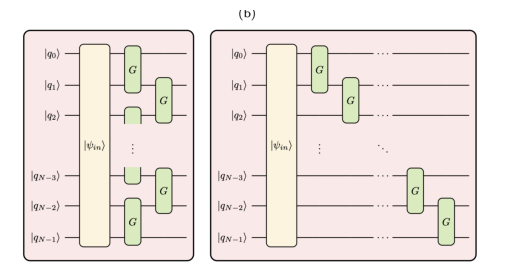

In [173]:
img = mpimg.imread('/Users/lorenzospera/Desktop/S_model/Applyingansatz.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Reference state 1 
The firts reference state considered in the paper is 
$$
\ket{\psi_{in}} = \left(\frac{1}{\sqrt{2}}(\ket{01}-\ket{10})\right)^{\otimes N}
$$
which is basically the $N$ tensor product state of the Bell state $\ket{\psi^{-}} = \frac{1}{\sqrt{2}}(\ket{01}-\ket{10})$

In [174]:
def create_reference_circuit_1(N):
    """
    Function that creates the reference circuit for the first reference state considered in the paper.
    Inputs:
    - N, numer of lattice sites 

    Returns : Quantum Circuit
    """
    num_qubits = 2*N
    qc = QuantumCircuit(num_qubits)

    for i in range(N):
        qc.h(2*i)                                   # apply the Hadamard gate to the first qubit of each pair 
        qc.cx(2*i, 2*i +1)                          # apply the CNOT gate to the first and second qubit of each pair
        qc.x(2*i +1)                                # apply the Pauli X gate to the second qubit of each pair     
        qc.z(2*i +1)                                # apply the Pauli Z gate to the second qubit of each pair    

    return qc 

In [175]:
reference_circuit_1 = create_reference_circuit_1(2)
sv = Statevector.from_instruction(reference_circuit_1)
sv.draw("latex")

<IPython.core.display.Latex object>

which is exactly the state we get for $N = 2$ lattice sites. 

### Ladder and Brick ansatz for both SO(4) and RXXYY


In [176]:
theta = Parameter("θ")

In [177]:
def create_full_ansatz1_SO4_ladder(N, n_layers):
    """
    Function that implements the whole ansatz (for G = SO(4)): reference circuit + ansatz and combine them in the ladder configuration

    Inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 

    """
    num_qubits = 2*N
    rf = create_reference_circuit_1(N)                                      # create reference circuit for the first reference state 
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state 
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the ladder configuration 

    SO4_ansatz = create_SO4(all_thetas)
    for i in range(n_layers):
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
            complete_ansatz.barrier()

    return complete_ansatz


def create_full_brick_ansatz1_SO4(N, n_layers):
    """
    Function that implements the whole ansatz (for G = SO(4)): reference circuit + ansatz and combine them in the brick configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    rf = create_reference_circuit_1(N)                                      # create reference circuit for the first reference
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the brick configuration

    SO4_ansatz = create_SO4(all_thetas)
    for i in range(n_layers): 
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

        for k in range(N-1):
            first_index = 2*k+1
            second_index = 2*k +2
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

    return complete_ansatz



def create_full_ansatz1_RXYY_ladder(N, n_layers):
    """
    Function that implements the whole ansatz (for G = RXYY): reference circuit + ansatz and combine them in the ladder configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    rf = create_reference_circuit_1(N)                                             # create reference circuit for the first reference state 
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    complete_ansatz.compose(rf ,inplace = True)                                    # first apply the reference circuit to create the reference state 
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the ladder configuration 

    R_XXYY = create_R_XXYY(theta)                                                  # create the R_XXYY circuit   
    for i in range(n_layers):     
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
            complete_ansatz.barrier()

    return complete_ansatz


def create_full_brick_ansatz1_RXXYY(N, n_layers):
    """
    Function that implements the whole ansatz (for G = RXYY): reference circuit + ansatz and combine them in the brick configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    rf = create_reference_circuit_1(N)                                      # create reference circuit for the first reference
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the brick configuration
    R_XXYY = create_R_XXYY(theta)
    for i in range(n_layers):
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

        for k in range(N-1):
            first_index = 2*k+1
            second_index = 2*k +2
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

    return complete_ansatz

## Reference state 2 
We will now consider the second reference state, which, accordin to the paper, is suitable for testing the model in the regime $\theta > \pi$, value for which the model should exhibit a production of a particle-antiparticle pair. The reference state is 
$$
\ket{\psi_{in}} = \ket{11}\otimes \bigg[\frac{1}{\sqrt{2}}(\ket{01}-\ket{10})\bigg]^{\otimes (N-2)}\otimes \ket{00}
$$
To create this state we complement the last two qubits (remeber qiskit convention) and create the fourth Bell state $N-2$ times. 

In [178]:
def create_reference_circuit_2(N):
    """
    Function that created the reference state 2.
    Inputs:
    N (int) = Number of lattice sites 

    Returns: 
    QuantumCircuit
    """
    num_qubits = 2*N
    qc = QuantumCircuit(num_qubits)

    # remeber Qiskti convention, the upmost qubit corrsponds to the right-most in the tensor product 
    qc.x(num_qubits-1)
    qc.x(num_qubits-2)
    qc.barrier()

    # create the bell state N-2 times 
    for i in range(1,N-1):
        qc.h(2*i)                                   # apply the Hadamard gate to the first qubit of each pair 
        qc.cx(2*i, 2*i +1)                          # apply the CNOT gate to the first and second qubit of each pair
        qc.x(2*i +1)                                # apply the Pauli X gate to the second qubit of each pair     
        qc.z(2*i +1)                                # apply the Pauli Z gate to the second qubit of each pair    
    
    qc.barrier()

    return qc

In [179]:
# check that the circuit produces the correct state for N = 3 lattice sites 
reference_circuit_2 = create_reference_circuit_2(N = 3)
reference_state_2 = Statevector.from_instruction(reference_circuit_2)
reference_state_2.draw("latex")

<IPython.core.display.Latex object>

Which is exactly the state one gets for $N = 3$ lattice sites.

Below, we define the two possible ansatz for $SO(4)$ and $R_{XX+YY}$.

In [180]:
def create_full_ansatz2_SO4_ladder(N, n_layers):
    """
    Function that implements the whole ansatz (for G = SO(4)): reference circuit + ansatz and combine them in the ladder configuration

    Inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 

    """
    num_qubits = 2*N
    rf = create_reference_circuit_2(N)                                      # create reference circuit for the second reference state 
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state 
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the ladder configuration 

    SO4_ansatz = create_SO4(all_thetas)
    for i in range(n_layers):
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
            complete_ansatz.barrier()

    return complete_ansatz


def create_full_brick_ansatz2_SO4(N, n_layers):
    """
    Function that implements the whole ansatz (for G = SO(4)): reference circuit + ansatz and combine them in the brick configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    rf = create_reference_circuit_2(N)                                      # create reference circuit for the second reference
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the brick configuration

    SO4_ansatz = create_SO4(all_thetas)
    for i in range(n_layers): 
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

        for k in range(N-1):
            first_index = 2*k+1
            second_index = 2*k +2
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

    return complete_ansatz



def create_full_ansatz2_RXYY_ladder(N, n_layers):
    """
    Function that implements the whole ansatz (for G = RXYY): reference circuit + ansatz and combine them in the ladder configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    rf = create_reference_circuit_2(N)                                             # create reference circuit for the second reference state 
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    complete_ansatz.compose(rf ,inplace = True)                                    # first apply the reference circuit to create the reference state 
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the ladder configuration 

    R_XXYY = create_R_XXYY(theta)                                                  # create the R_XXYY circuit   
    for i in range(n_layers):     
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
            complete_ansatz.barrier()

    return complete_ansatz


def create_full_brick_ansatz2_RXXYY(N, n_layers):
    """
    Function that implements the whole ansatz (for G = RXYY): reference circuit + ansatz and combine them in the brick configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    rf = create_reference_circuit_2(N)                                       # create reference circuit for the second reference
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the brick configuration
    R_XXYY = create_R_XXYY(theta)
    for i in range(n_layers):
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

        for k in range(N-1):
            first_index = 2*k+1
            second_index = 2*k +2
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

    return complete_ansatz

## Reference state 3
A reference state of the form $\ket{10}^{\otimes N}$ can be expande as
$$
\ket{1}\otimes \ket{0} \otimes \ket{1} \otimes \ket{0} \otimes \cdots \otimes \ket{1} \otimes \ket{0}
$$
For $N = 2$ we have 
$$\ket{1} \otimes \ket{0} \otimes \ket{1} \otimes \ket{0}  $$
which means that qubits specified by an even index get the state $\ket{0}$, while the qubits specified by an odd index get the state $\ket{1}$. 

In [181]:
def create_reference_circuit3(N):
    """
    Function that returns the circuit that create the third reference state.

    Input : number of lattice sites
    Returns : quantum circuit that creates the reference state 
    """
    num_qubits = 2*N
    qc = QuantumCircuit(num_qubits)
    for i in range(N):
        qc.x(2*i+1)                                                   
    
    # leave the other N qubits unchanged (in the state |0>)

    return qc   

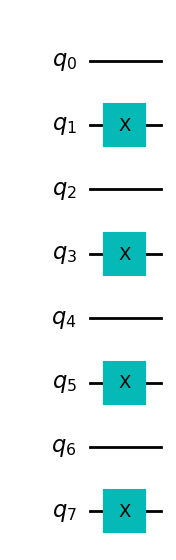

In [182]:
# create the circuit for N = 4
N = 4
reference_circuit_3 = create_reference_circuit3(N)
reference_circuit_3.draw(output = "mpl", style = "clifford")

In [183]:
# get the reference state 
reference_state_3 = Statevector.from_instruction(reference_circuit_3)
reference_state_3.draw("latex")

<IPython.core.display.Latex object>

### Ladder Ansatz for SO(4)

In [184]:
def create_full_ansatz3_SO4_ladder(N, n_layers):
    """
    Function that implements the whole ansatz (for G = SO(4)): reference circuit + ansatz and combine them in the ladder configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    rf = create_reference_circuit3(N)                                       # create reference circuit for the third reference state 
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state 
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the ladder configuration 

    SO4_ansatz = create_SO4(all_thetas)
    for i in range(n_layers):
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
            complete_ansatz.barrier()

    return complete_ansatz

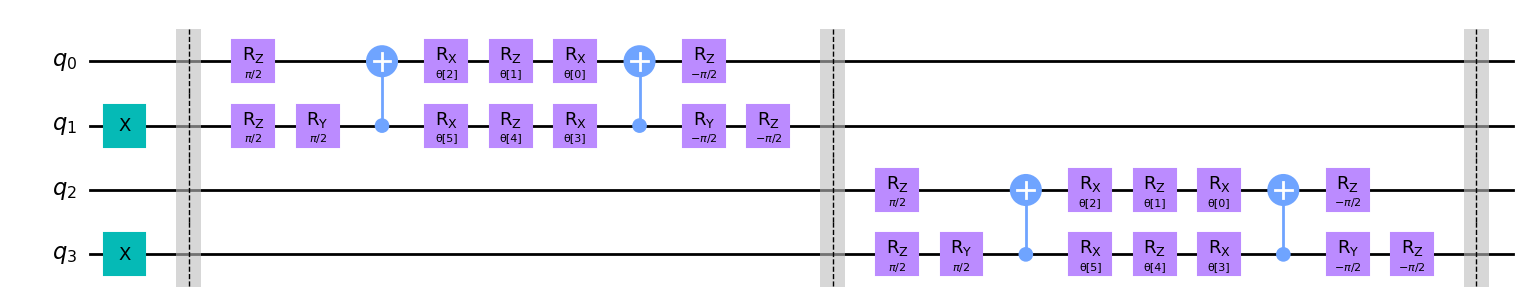

In [185]:
# create an example for N = 2 lattice sites 
N = 2
# create the complete ansatz 
full_ansatz_SO4_ladder = create_full_ansatz3_SO4_ladder(N, 1)
full_ansatz_SO4_ladder.draw(output = "mpl", style = "clifford" )

### Brick ansatz for SO(4)


In [186]:
def create_full_brick_ansatz3_SO4(N, n_layers):
    """
    Function that implements the whole ansatz (for G = SO(4)): reference circuit + ansatz and combine them in the brick configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    rf = create_reference_circuit3(N)                                       # create reference circuit for the third reference
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the brick configuration
    SO4_ansatz = create_SO4(all_thetas)
    for i in range(n_layers): 
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

        for k in range(N-1):
            first_index = 2*k+1
            second_index = 2*k +2
            complete_ansatz.compose(SO4_ansatz, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

    return complete_ansatz
    

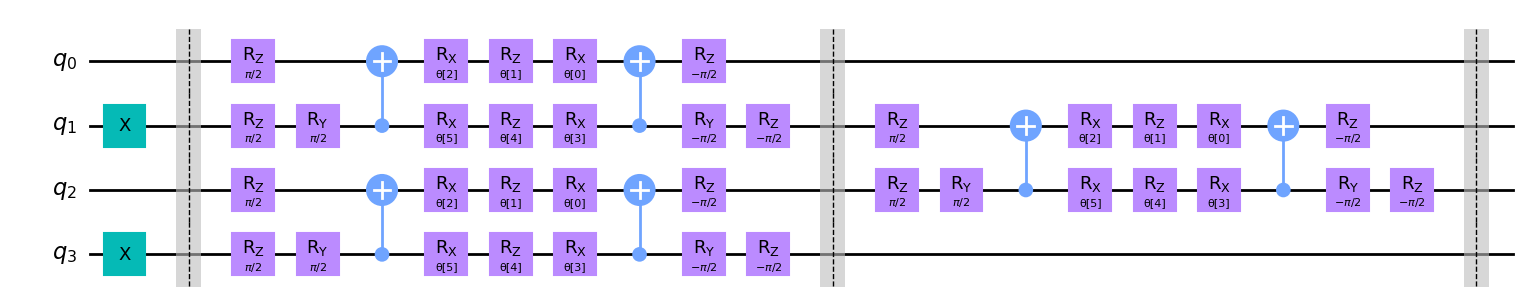

In [187]:
# consider an example for N = 2 lattice sites
N = 2
# create the complete ansatz 
full_ansatz_SO4_brick = create_full_brick_ansatz3_SO4(N,1)
full_ansatz_SO4_brick.draw(output = "mpl", style = "clifford" )

### Ladder Ansatz for RXXYY




In [188]:
theta = Parameter("θ")

In [189]:
def create_full_ansatz3_RXYY_ladder(N, n_layers):
    """
    Function that implements the whole ansatz (for G = RXYY): reference circuit + ansatz and combine them in the ladder configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    
    num_qubits = 2*N
    rf = create_reference_circuit3(N)                                       # create reference circuit for the third reference state 
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state 
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the ladder configuration 

    R_XXYY = create_R_XXYY(theta)                                            # create the R_XXYY circuit 
    for i in range(n_layers):        
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
            complete_ansatz.barrier()

    return complete_ansatz

### Brick ansatz for RXXYY 

In [190]:
def create_full_brick_ansatz3_RXXYY(N, n_layers):
    """
    Function that implements the whole ansatz (for G = RXYY): reference circuit + ansatz and combine them in the brick configuration

    inputs : 
    - N number of lattice sites 
    - n_layers = number of times the ansatz is repeated 
    
    Returns :
    - complete_ansatz(QuantumCircuit) : full ansatz with the reference state and the parametric part 
    """
    num_qubits = 2*N
    qr = QuantumRegister(num_qubits, 'q')
    complete_ansatz = QuantumCircuit(qr)
    rf = create_reference_circuit3(N)                                       # create reference circuit for the third reference
    complete_ansatz.compose(rf ,inplace = True)                             # first apply the reference circuit to create the reference state
    complete_ansatz.barrier()

    # apply the SO(4) ansatz to each pair in the brick configuration
    R_XXYY = create_R_XXYY(theta)
    for i in range(n_layers):
        for k in range(N):
            first_index = 2*k
            second_index = 2*k +1
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

        for k in range(N-1):
            first_index = 2*k+1
            second_index = 2*k +2
            complete_ansatz.compose(R_XXYY, qubits = [qr[first_index], qr[second_index]], inplace = True)
        complete_ansatz.barrier()

    return complete_ansatz

# VQE results for reference state 1 in the m/g = 10 case 
In this section we will apply the VQE procedure for the different ansatzes and configuration of the system, in particular to reference state 1. 


## Reference state 1 N = 3
We start by applying the VQE procedure for reference state $\theta < \pi $. 

In [191]:
from scipy.sparse.linalg import eigsh

# create the Hamiltonian for N = 3 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 3, x = (N**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 3 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 3, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 3, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 3 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 3, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 3 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999997,-3.846667,-3.846678
1,R_{XX+YY},0.999994,-3.846667,-3.846689


In [192]:
particle_operator = create_particle_number_operator(N = 3)
particle_operator


SparsePauliOp(['IIIIXX', 'IIIIYY', 'IIXXII', 'IIYYII', 'XXIIII', 'YYIIII', 'IIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 3. +0.j])

In [193]:
optimal_vector.expectation_value(particle_operator).real

np.float64(6.476685854295283e-11)

## Reference state 1 and N = 4 lattice sites 
We can repeat the same procedure for $N = 4$ lattice sites in the same limit as before.

In [194]:
# create the Hamiltonian for N = 4 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 4, x = (4**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 4 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 4, lam = 2)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 4, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 4 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 4, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 4 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999959,-10.538889,-10.539164
1,R_{XX+YY},0.999953,-10.538889,-10.539188


## Reference state 1 and N = 5 lattice sites 
We can repeat the same procedure for $N = 5$ lattice sites in the same limit as before.

In [195]:
# create the Hamiltonian for N = 5 lattice sites containing the penalty term for the vanishing total charge
hamiltonian = create_discretized_hamiltonian(N = 5, x = (5**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 
penalty_term = create_penalty_term(N = 5, lam = 10)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 5, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 5 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 5, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 5 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999917,-16.584444,-16.585130
1,R_{XX+YY},0.999896,-16.584444,-16.585243


## Reference state 1 and N = 6 lattice sites 
We can repeat the same procedure for $N = 5$ lattice sites in the same limit as before.

In [196]:
# create the Hamiltonian for N = 6 lattice sites containing the penalty term for the vanishing total charge
hamiltonian = create_discretized_hamiltonian(N = 6, x = (6**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 
penalty_term = create_penalty_term(N = 6, lam = 10)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 6, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 6 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 6, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 6 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999837,-24.03,-24.031571
1,R_{XX+YY},0.999807,-24.03,-24.031754


# VQE results for reference state 1 in the m/g = 0 case 
In this section we will apply the VQE procedure for the different ansatzes and configuration of the system, in particular to reference state 1. 

## Reference state 1 N = 3
We start by applying the VQE procedure for reference state $\theta < \pi $. 

In [197]:
# create the Hamiltonian for N = 3 lattice sites, m_lat = 0, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 3, x = (3**2)/900, m_lat = 0, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 3 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 3, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 3, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 3 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 3, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 3 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999384,0.12,0.119709
1,R_{XX+YY},0.998728,0.12,0.119417


## Reference state 1 N = 4

In [198]:
# create the Hamiltonian for N = 4 lattice sites, m_lat = 0, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 4, x = (4**2)/900, m_lat = 0, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 4 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 4, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 4, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 4 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 4, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 4 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.996396,0.127779,0.126028
1,R_{XX+YY},0.994562,0.127778,0.125149


## Reference state 1 N = 5

In [199]:
# create the Hamiltonian for N = 5 lattice sites, m_lat = 0, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 5, x = (4**2)/900, m_lat = 0, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 5 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 5, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 5, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 5 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 5, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 5 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.994520,0.182224,0.179593
1,R_{XX+YY},0.992702,0.182222,0.178715


## Reference state 1 N = 6

In [200]:
# create the Hamiltonian for N = 6 lattice sites, m_lat = 0, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 6, x = (4**2)/900, m_lat = 0, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 6 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 6, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_1 = create_full_brick_ansatz1_SO4(N = 6, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 6 and reference state 1

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_1, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_1 = create_full_brick_ansatz1_RXXYY(N = 6, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 6 and reference state 1 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_1, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_1.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.992680,0.236667,0.233159
1,R_{XX+YY},0.990847,0.236667,0.232280


# VQE results for reference state 3 
We will now do the same for reference state 3. 
 

## Reference state 3 N = 3

In [201]:
# create the Hamiltonian for N = 3 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 3, x = (N**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 3 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 3, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_brick_ansatz_rf_3 = create_full_brick_ansatz3_SO4(N = 3, n_layers= 1)                                                        # create the SO(4) brick ansatz for N = 3 and reference state 3

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_brick_ansatz_rf_3, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_brick_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY brick ansatz 
RXXYY_brick_ansatz_rf_3 = create_full_brick_ansatz3_RXXYY(N = 3, n_layers= 1)                                                   # create the RXYY brick ansatz for N = 3 and reference state 3 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_brick_ansatz_rf_3, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_brick_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.128006,0.163985,-3.846678
1,R_{XX+YY},0.612994,-2.244248,-3.846689


As we can see from the fidelity obtained by using both ansatz we get a result far from the exact diagonalitazion. One possible reason is that, given this reference state, the ansatz is not sufficient to explore a great range of possible states in the Hilber space. Below, we try with the ladder ansatz for both $SO(4)$ and $R_{XX+YY}$.

In [202]:
# create the Hamiltonian for N = 3 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 3, x = (N**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 3 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 3, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_ladder_ansatz_rf_3 = create_full_ansatz3_SO4_ladder(N = 3, n_layers= 1)                                                      # create the SO(4) ladder ansatz for N = 3 and reference state 3

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_ladder_ansatz_rf_3, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY ladder ansatz 
RXXYY_ladder_ansatz_rf_3 = create_full_ansatz3_RXYY_ladder(N = 3, n_layers= 1)                                                   # create the RXYY ladder ansatz for N = 3 and reference state 3 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_ladder_ansatz_rf_3, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999997,-3.846667,-3.846678
1,R_{XX+YY},0.999994,-3.846667,-3.846689


## Reference state 3 N = 4


In [203]:
# create the Hamiltonian for N = 4 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 4, x = (4**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 4 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 4, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_ladder_ansatz_rf_3 = create_full_ansatz3_SO4_ladder(N = 4, n_layers= 1)                                                      # create the SO(4) ladder ansatz for N = 4 and reference state 3

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_ladder_ansatz_rf_3, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY ladder ansatz 
RXXYY_ladder_ansatz_rf_3 = create_full_ansatz3_RXYY_ladder(N = 4, n_layers= 1)                                                   # create the RXYY ladder ansatz for N = 4 and reference state 3 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_ladder_ansatz_rf_3, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999968,-10.538889,-10.539089
1,R_{XX+YY},0.999953,-10.538889,-10.539188


## Reference state 3 N = 5

In [204]:
# create the Hamiltonian for N = 5 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 5, x = (5**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 5 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 5, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_ladder_ansatz_rf_3 = create_full_ansatz3_SO4_ladder(N = 5, n_layers= 1)                                                      # create the SO(4) ladder ansatz for N = 5 and reference state 3

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_ladder_ansatz_rf_3, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY ladder ansatz 
RXXYY_ladder_ansatz_rf_3 = create_full_ansatz3_RXYY_ladder(N = 5, n_layers= 1)                                                   # create the RXYY ladder ansatz for N = 5 and reference state 3 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_ladder_ansatz_rf_3, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999922,-16.584444,-16.585045
1,R_{XX+YY},0.999896,-16.584444,-16.585243


## Reference state 3 N = 6 

In [205]:
# create the Hamiltonian for N = 6 lattice sites, m_lat = 10, g = 1, x = 1 and l0 = 1
hamiltonian = create_discretized_hamiltonian(N = 6, x = (6**2)/900, m_lat = 10, g = 1, l0 = 0.3)
matrix_hamiltonian = hamiltonian.to_matrix(sparse = True)

eigenvalues, eigenvector = eigsh(matrix_hamiltonian, which = 'SA')                                               # 'SA' for smallest algebraic eigenvalue
min_eigenvalue = min(eigenvalues)                                                                                # get the minimum eigenvalue 
min_eigenvector = eigenvector[:, np.argmin(eigenvalues)]                                                         # get the corresponding eigenvector 

# create the Hamiltonian for N = 6 lattice sites containing the penalty term for the vanishing total charge
penalty_term = create_penalty_term(N = 6, lam = 1000)
penalty_hamiltonian = hamiltonian + penalty_term

matrix_penalty_hamiltonian = penalty_hamiltonian.to_matrix(sparse = True)
penalty_eigenvalues, penalty_eigenvectors = eigsh(matrix_penalty_hamiltonian, which = 'SA')                                      # 'SA' for smallest algebraic eigenvalue

min_penalty_eigenvalue = min(penalty_eigenvalues)                                                                                # get the minimum eigenvalue 
min_penalty_eigenvector = penalty_eigenvectors[:, np.argmin(penalty_eigenvalues)]                                                # get the corresponding eigenvector 
# --------------------------------------------------------------------------------------------#

S04_ladder_ansatz_rf_3 = create_full_ansatz3_SO4_ladder(N = 6, n_layers= 1)                                                      # create the SO(4) ladder ansatz for N = 6 and reference state 3

initial_point = np.random.uniform(low = 0, high = 0.01, size = 6)
vqe_estimator = Estimator()
vqe_result = minimize(cost_func_vqe, initial_point, args = (S04_ladder_ansatz_rf_3, penalty_hamiltonian, vqe_estimator ), method = "L-BFGS-B", options = {'maxiter': 2000})

# get the optimal parameters and the optimal state from the ansatz 
optimal_params = vqe_result.x
optimal_c = S04_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector = Statevector.from_instruction(optimal_c)
fidelity_result_SO4 = state_fidelity(optimal_vector, min_penalty_eigenvector)

# --------------------------------------------------------------------------------------------#

# do the same for the RXXYY ladder ansatz 
RXXYY_ladder_ansatz_rf_3 = create_full_ansatz3_RXYY_ladder(N = 6, n_layers= 1)                                                   # create the RXYY ladder ansatz for N = 6 and reference state 3 
initial_theta = np.random.uniform(low = 0, high = 0.001, size = 1)
vqe_result_RXXYY = minimize(cost_func_vqe, initial_theta, args = (RXXYY_ladder_ansatz_rf_3, hamiltonian, vqe_estimator), method = "L-BFGS-B", options = {'maxiter': 2000} )
optimal_params = vqe_result_RXXYY.x
optimal_c = RXXYY_ladder_ansatz_rf_3.assign_parameters(optimal_params)
optimal_vector_RXXYY = Statevector.from_instruction(optimal_c)
fidelity_result_RXXYY = state_fidelity(optimal_vector_RXXYY, min_eigenvector)


# we can display the result for the two ansatz 
df = pd.DataFrame({
    'Ansatz': ['SO(4)', 'R_{XX+YY}'],
    'Fidelity': [fidelity_result_SO4, fidelity_result_RXXYY],
    'VQE energy' : [vqe_result.fun, vqe_result_RXXYY.fun],
    'Smallest Eigenvalue': [min_penalty_eigenvalue, min_eigenvalue]
})
df

,Ansatz,Fidelity,VQE energy,Smallest Eigenvalue
0,SO(4),0.999845,-24.03,-24.031407
1,R_{XX+YY},0.999807,-24.03,-24.031754


# Computing expectation values 
Now that we have shown the procedure on how to approximate the ground state of the system and obtain the corresponding state from the ansatz, we can run the procedure for different values of $l_0$ and compute the expectation values of the particle number operator $P_W$ and electric field $L_W$ in order to locate the presence of a phase transition. 

In [214]:
# define the function to compute the expectation value of the particle number operator for the SO4 ansatz 
def compute_expectation_value_particle_operator(operator, l0_values, N_sites, mlat):

    """
    Function that computes the expectation value of a particle number operator as a sum of Pauli strings on the optimal state obtained from the VQE.compute_minimum_eigenvalue
    Inputs:
    - operator (SparsePauliOp) : the operator to compute the expectation value of 
    - ansatz (QuantumCircuit) :  parametric quantum circuit used in the VQE procedure 
    - initial_parameters : initial values of the parameters to use in the ansatz 
    - l0_values : list of l0 values to compute the expectation value to spot the presence of a phase transition
    - N : number of lattice sites 
    """

    l0_vals = l0_values                                                                                     
    evals = []                                                                                      # list to store expectation values                                 
    hamiltonians = []                                                                               # list to store hamiltonians for each value of l0 
    optimal_vectors = []                                                                            # list to store the optimal vectors obtained by the VQE procedure
    evals_exact = []                                                                                # list to store the expectation values from exact diagonalization
    exact_vectors = []                                                                              # list to store the vectors obtained from exact diagonalization

    estimator_vqe = Estimator()                                                                     # estimator to get the minimum value of the energy

    for l0 in l0_values:
        hamiltonian = create_discretized_hamiltonian(N = N_sites, x = (N_sites**2)/900, m_lat = mlat, g = 1, l0 = l0) + create_penalty_term(N = N_sites, lam = 1e4)
        hamiltonians.append(hamiltonian)

        matrix = hamiltonian.to_matrix(sparse = True)
        eigenvalues, eigenvectors = eigsh(matrix,  which = 'SA')
        min_eigenvector = eigenvectors[:,np.argmin(eigenvalues)]
        exact_vectors.append(min_eigenvector)


    # now, for each Hamiltonian we run the VQE procedure 

    for i in range(len(hamiltonians)):
        initial_parameters = np.random.uniform(0, 0.001, 6)
        if (i <3) :
            ansatz = create_full_brick_ansatz1_SO4(N = N_sites, n_layers = 1)
            result_vqe = minimize(cost_func_vqe, initial_parameters, args = (ansatz, hamiltonians[i], estimator_vqe), method = 'L-BFGS-B', options = {'maxiter' : 2000})

            # get the optimal parameters to compute the optimal vector 
            optima_parameters = result_vqe.x
            optimal_circuit = ansatz.assign_parameters(optima_parameters)

            # get the optimal vector from the parametric quantum circuit 

            optimal_state = Statevector.from_instruction(optimal_circuit)
            optimal_vectors.append(optimal_state)

        else:

            ansatz = create_full_brick_ansatz2_SO4(N = N_sites, n_layers = 5)
            result_vqe = minimize(cost_func_vqe, initial_parameters, args = (ansatz, hamiltonians[i], estimator_vqe), method = 'L-BFGS-B', options = {'maxiter' : 2000})

            # get the optimal parameters to compute the optimal vector 
            optima_parameters = result_vqe.x
            optimal_circuit = ansatz.assign_parameters(optima_parameters)

            # get the optimal vector from the parametric quantum circuit 

            optimal_state = Statevector.from_instruction(optimal_circuit)
            optimal_vectors.append(optimal_state)
            initial_parameters = optima_parameters

    for opvec in optimal_vectors:
        eval = opvec.expectation_value(operator)
        evals.append(eval.real)

    matrix_operator = operator.to_matrix(sparse = True)
    for vec in exact_vectors:
        eval_exact = np.vdot(vec, matrix_operator @ vec)
        evals_exact.append(eval_exact.real)
        
    
    # return the values and l0 and the expectation value of the operator 

    return l0_vals, evals, evals_exact

In [223]:
l0_total = []
evals_total = []
evals_exact = []

In [224]:
# --------------------------------------------------------------------------- #
operator = create_particle_number_operator(N = 3)
l0_values3 = np.linspace(1.509, 1.511, 6)
N_sites = 3
l0vals3, evals3, evals_exact3 = compute_expectation_value_particle_operator(operator = operator, l0_values = l0_values3, N_sites = N_sites, mlat = 10)

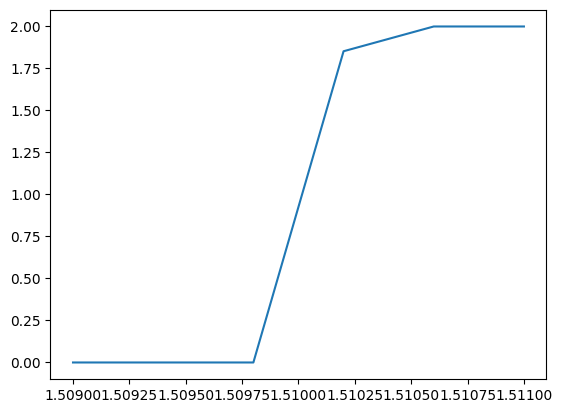

In [225]:
plt.plot(l0vals3, evals3)

In [226]:
l0_total.append(l0vals3)
evals_total.append(evals3)
evals_exact.append(evals_exact3)

In [ ]:
# # --------------------------------------------------------------------------- #
operator = create_particle_number_operator(N = 4)
l0_values4 = np.linspace(1.380, 1.420, 6)
N_sites = 4
l0vals4, evals4, evals_exact4 = compute_expectation_value_particle_operator(operator = operator, l0_values = l0_values4, N_sites = N_sites, mlat = 10)
l0_total.append(l0vals4)
evals_total.append(evals4)
evals_exact.append(evals_exact4)
# --------------------------------------------------------------------------- #
operator = create_particle_number_operator(N = 5)
l0_values5 = np.linspace(1.343, 1.4, 6)
N_sites = 5
l0vals5, evals5, evals_exact5 = compute_expectation_value_particle_operator(operator = operator, l0_values = l0_values5, N_sites = N_sites, mlat = 10)
l0_total.append(l0vals5)
evals_total.append(evals5)
evals_exact.append(evals_exact5)
# --------------------------------------------------------------------------- #
operator = create_particle_number_operator(N = 6)
l0_values6 = np.linspace(1.290, 1.32, 6)
N_sites = 6
l0vals6, evals6, evals_exact6 = compute_expectation_value_particle_operator(operator = operator, l0_values = l0_values6, N_sites = N_sites, mlat = 10)
l0_total.append(l0vals6)
evals_total.append(evals6)
evals_exact.append(evals_exact6)


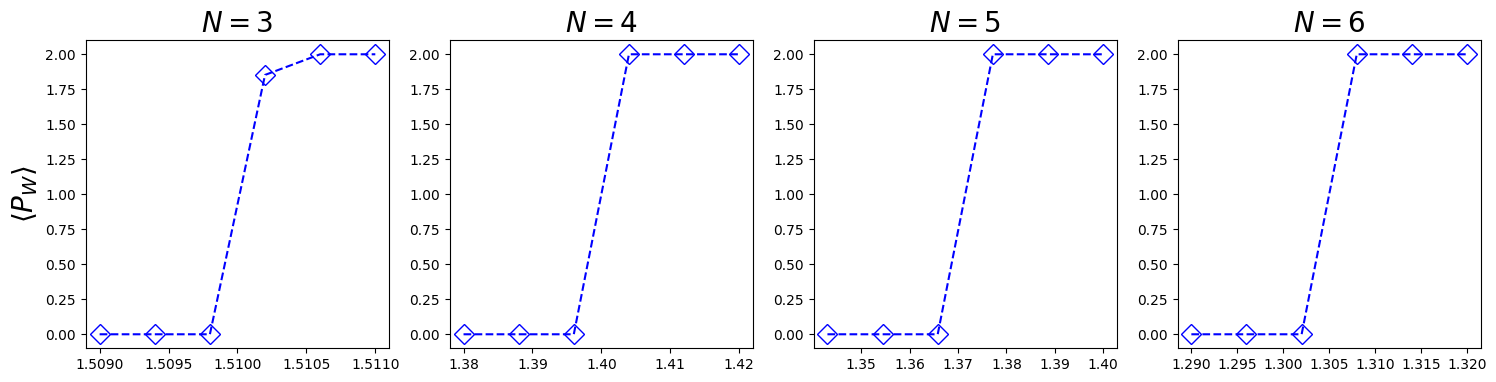

In [228]:
fig, ax = plt.subplots(nrows = 1, ncols  = 4, figsize = [18,4])
N_list = [3,4,5,6]
for i in range(len(evals_total)):
    ax[i].plot(l0_total[i], evals_total[i], "D", linestyle = "--", markersize = 10, markerfacecolor='none', c = "blue")
    #ax[i].plot(l0_total[i], evals_exact[i], "o" )
ax[0].set_ylabel(r"$\langle P_W\rangle$", size = 20)
ax[0].set_title(r"$N = 3$", size = 20)
ax[1].set_title(r"$N = 4$", size = 20)
ax[2].set_title(r"$N = 5$", size = 20)
ax[3].set_title(r"$N = 6$", size = 20)
fig.tight_layout = True
plt.show()

# References 
- [1] Takis Angelides, Pranay Naredi, Arianna Crippa, Karl Jansen, Stefan Kühn, Ivano Tavernelli, Derek S. Wang, First-Order Phase Transition of the Schwinger Model with a Quantum Computer. Arxive : https://arxiv.org/abs/2312.12831
